In [1]:
import operator
import math
from functools import reduce
import json
from os.path import join, isfile, isdir

import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from expdir_monitor.expdir_monitor import ExpdirMonitor
from data_providers.utils import get_data_provider_by_name
from models.utils import get_model_by_name

/home/cthavama/miniconda3/envs/eas/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cthavama/miniconda3/envs/eas/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cthavama/miniconda3/envs/eas/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cthavama/miniconda3/envs/eas/lib/python3

In [2]:
def get_model(id, net_pool_path):
    if isdir(f'{net_pool_path}/#{id}'):
        em = ExpdirMonitor(f'{net_pool_path}/#{id}')
    else:
        em = ExpdirMonitor(f'{net_pool_path}/#Running_{id}')
    pure = True

    init = em.load_init()
    run_config = em.load_run_config(print_info=(not pure), dataset='C10+')
    run_config.renew_logs = False

    data_provider = get_data_provider_by_name(run_config.dataset, run_config.get_config())
    net_config, model_name = em.load_net_config(init, print_info=(not pure))
    return get_model_by_name(model_name)(em.expdir, data_provider, run_config, net_config, pure=pure)
    

def get_num_params(id, net_pool_path):
    model = get_model(id, net_pool_path)
    with model.graph.as_default():
        total_parameters = 0
        for variable in tf.trainable_variables():
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            total_parameters += variable_parameters
    return total_parameters

def get_num_params_efficient_helper(path):
    em = ExpdirMonitor(path)
    init = em.load_init()
    total_params = 0
    if init is None:
        print(id, net_pool_path)
    for layer in init['layer_cascade']['layers']:
        if layer is None:
            continue
        for k, v in layer.items():
            if 'moving_' not in k:
                total_params += reduce(operator.mul, v.shape)
    return total_params

def get_num_params_efficient(id, net_pool_path):
    if isdir(f'{net_pool_path}/#{id}'):
        return get_num_params_efficient_helper(f'{net_pool_path}/#{id}')
    else:
        return get_num_params_efficient_helper(f'{net_pool_path}/#Running_{id}')

In [50]:
# RECOVER net.id2params FILE IF NECESSARY

idpath2val = {}
idpath2str = {}

net_pool_path = '../net_pool_params1/Convnet/C10+/Conv_C10+_rl_small'
id2val = json.load(open(join(net_pool_path, 'net.id2val')))
for id in id2val:
    idpath2val[(id, net_pool_path)] = id2val[id]

idpath2params = {
    idpath: get_num_params_efficient(*idpath)
    for idpath in tqdm(idpath2val)
}

id2params = {
    idpath[0]: params
    for idpath, params in idpath2params.items()
}

json.dump(id2params, open('net.id2params', 'w'), indent=4)

In [3]:
def get_df(exp_name):
    net_pool_path = f'../net_pool_{exp_name}/Convnet/C10+/Conv_C10+_rl_small'
    arch_search_path = f'../arch_search_{exp_name}/Convnet/C10+/Conv_C10+_rl_small'

    id2val = json.load(open(join(net_pool_path, 'net.id2val')))
    id2params = json.load(open(join(net_pool_path, 'net.id2params')))

    with open(join(arch_search_path, 'net.log'), 'r') as f:
        lines = f.readlines()
        id2epoch = {
            id: int(line[:-1].split('\t')[0][:-1])
            for line in lines
            for id in line[:-1].split('\t')[2:]
        }

    ids = list(id2epoch.keys())
    
    epochs = [id2epoch[id] for id in ids]
    params = [id2params[id] for id in ids]
    vals = [id2val[id] for id in ids]

    df = pd.DataFrame({
        'id': ids,
        'epoch': epochs,
        'params': params,
        'vals': vals,
    })
    df['reward'] = np.tan(df.vals * np.pi/2)
    
    return df

# Params1

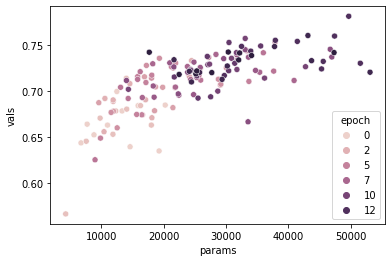

In [6]:
df_base1 = get_df('base1')
ax = sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch')

In [9]:
get_df('random').vals.max()

0.7140001

In [37]:
df = get_df('base1')
df['reward'] = np.tan(df.acc * np.pi/2)

,params,reward
params,1.00000,0.72476
reward,0.72476,1.00000


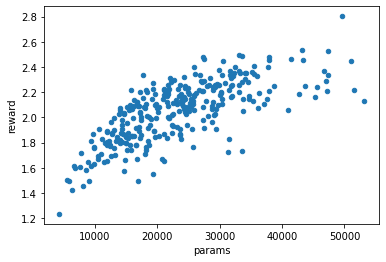

In [39]:
df.plot.scatter(x='params', y='reward')
df[['params', 'reward']].corr()

,logparams,acc
logparams,1.000000,0.776445
acc,0.776445,1.000000


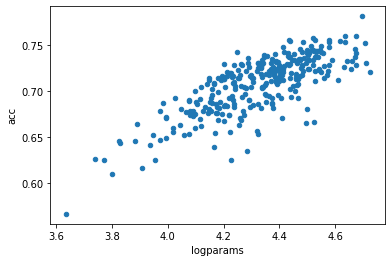

In [40]:
df['logparams'] = np.log10(df.params)
df.plot.scatter(x='logparams', y='acc')
df[['logparams', 'acc']].corr()

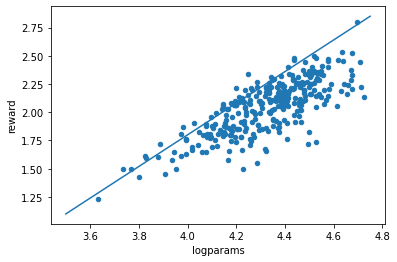

In [59]:
df['logparams'] = np.log10(df.params)
ax = df.plot.scatter(x='logparams', y='reward')
df[['logparams', 'reward']].corr()
x = [3.5, 4.75]
y = [1.4*x0-3.8 for x0 in x]
ax.plot(x,y)

<AxesSubplot:>

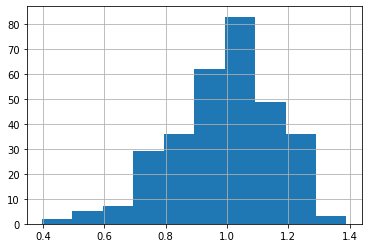

In [63]:
(df.reward - 1.4 * df.logparams + 5).hist()

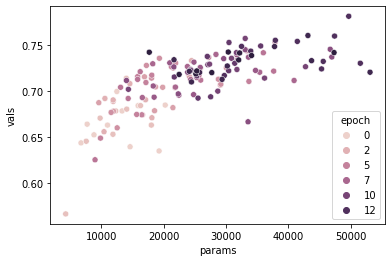

In [6]:
df_base1 = get_df('base1')
ax = sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch')

<AxesSubplot:xlabel='params', ylabel='vals'>

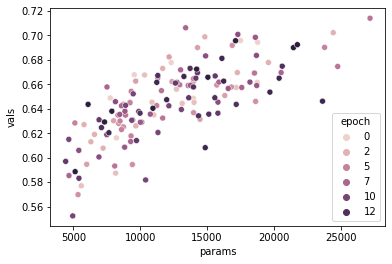

In [61]:
df_random = get_df('random')
sns.scatterplot(data=df_random, x='params', y='vals', hue='epoch')

<AxesSubplot:xlabel='params', ylabel='vals'>

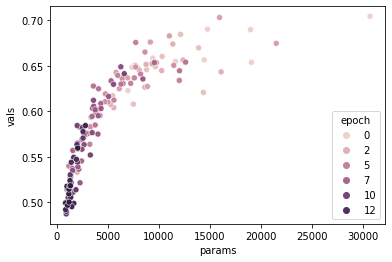

In [62]:
df_params1 = get_df('params1')
sns.scatterplot(data=df_params1, x='params', y='vals', hue='epoch')

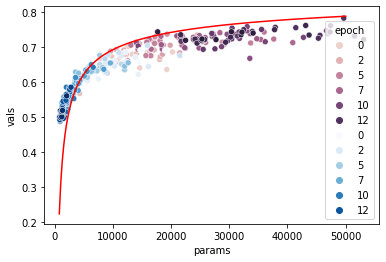

In [79]:
ax = sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch')
sns.scatterplot(data=df_params1, x='params', y='vals', hue='epoch', ax=ax, palette='Blues')

# rewards.append(5 + np.tan(net_val * np.pi / 2) - 1.4 * np.log10(params_list[i]))
x = np.linspace(800, 50000, 200)
y = np.arctan(1.3 - 5 + 1.4 * np.log10(x)) * 2 / np.pi
ax.plot(x,y, color='r')

In [70]:
get_num_params_efficient_helper('../start_nets/start_net_convnet_small_C10+')

710

In [68]:
df_params1.params.sort_values()

140      886
117      886
130      886
128      942
109      942
       ...  
25     16106
2      18986
7      19078
34     21506
9      30690
Name: params, Length: 148, dtype: int64

# Param2

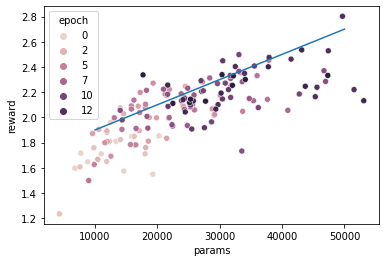

In [17]:
df_base1 = get_df('base1')
ax = sns.scatterplot(data=df_base1, x='params', y='reward', hue='epoch')
x= [10000, 50000]
y= [x0/10000/5 + 1.7 for x0 in x]
ax.plot(x,y)

<AxesSubplot:>

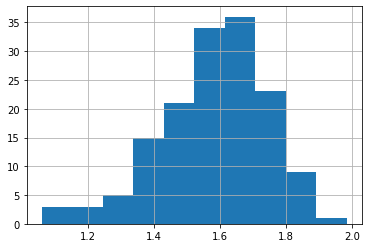

In [20]:
(df_base1.reward - df_base1.params/(5e4)).hist()

<AxesSubplot:xlabel='params', ylabel='vals'>

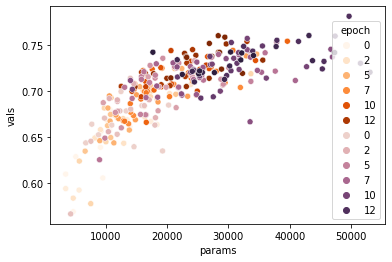

In [10]:
df_params2 = get_df('params2')
ax = sns.scatterplot(data=df_params2, x='params', y='vals', hue='epoch', palette='Oranges')
sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch', ax=ax)

[Text(0, 0.5, 'new_reward')]

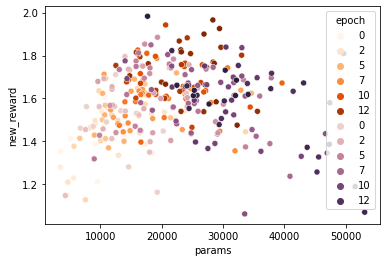

In [15]:
df_params2['reward2'] = df_params2.reward - df_params2.params/5e4
df_base1['reward2'] = df_base1.reward - df_base1.params/5e4

ax = sns.scatterplot(data=df_params2, x='params', y='reward2', hue='epoch', palette='Oranges')
sns.scatterplot(data=df_base1, x='params', y='reward2', hue='epoch', ax=ax)
ax.set(ylabel='new_reward')

In [22]:
df_params2.reward2.max()

1.9656830368634963

<AxesSubplot:>

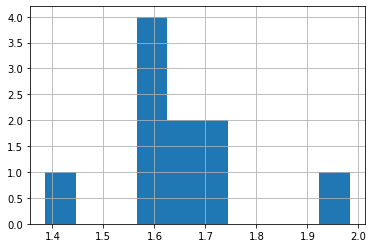

In [35]:
df_base1[df_base1.epoch == 14].reward2.hist()

<AxesSubplot:>

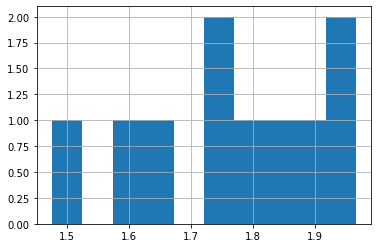

In [36]:
df_params2[df_params2.epoch == 14].reward2.hist()

# Iterative 1 and 2

<AxesSubplot:xlabel='params', ylabel='vals'>

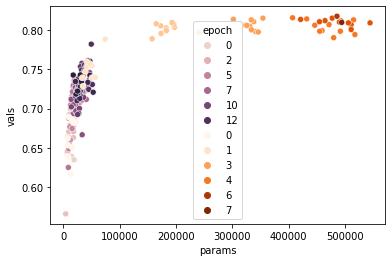

In [8]:
df_base1 = get_df('base1')
df_iterative1 = get_df('iterative1')
ax = sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch')
sns.scatterplot(data=df_iterative1, x='params', y='vals', hue='epoch', ax=ax, palette='Oranges')

<AxesSubplot:xlabel='params', ylabel='vals'>

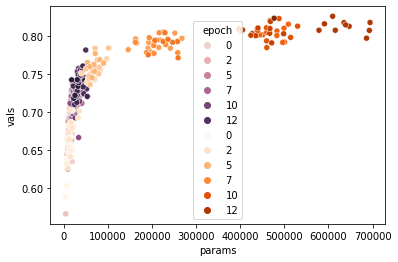

In [7]:
df_base1 = get_df('base1')
df_iterative2 = get_df('iterative2')
ax = sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch')
sns.scatterplot(data=df_iterative2, x='params', y='vals', hue='epoch', ax=ax, palette='Oranges')

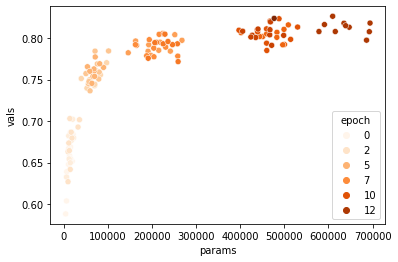

In [16]:
df_iterative2 = get_df('iterative2')
ax = sns.scatterplot(data=df_iterative2, x='params', y='vals', hue='epoch', palette='Oranges')

In [18]:
df_iterative2.vals.max()

0.8262

# Iterative Resource-Aware 1

<AxesSubplot:xlabel='params', ylabel='vals'>

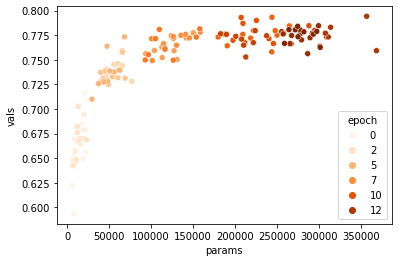

In [4]:
df_iterativeparams1 = get_df('iterativeparams1')
sns.scatterplot(data=df_iterativeparams1, x='params', y='vals', hue='epoch',  palette='Oranges')

<AxesSubplot:xlabel='params', ylabel='vals'>

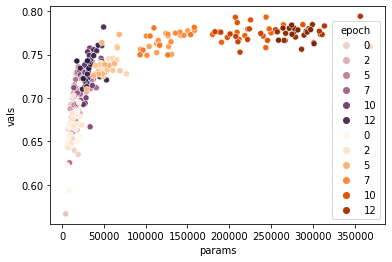

In [4]:
df_base1 = get_df('base1')
df_iterativeparams1 = get_df('iterativeparams1')
ax = sns.scatterplot(data=df_base1, x='params', y='vals', hue='epoch')
sns.scatterplot(data=df_iterativeparams1, x='params', y='vals', hue='epoch', ax=ax, palette='Oranges')

<AxesSubplot:xlabel='params', ylabel='reward2'>

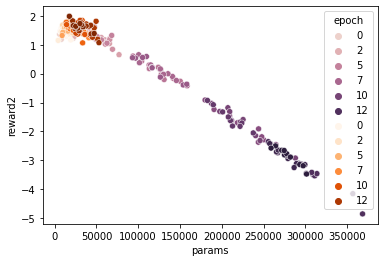

In [20]:
df_iterativeparams1['reward2'] = df_iterativeparams1.reward - df_iterativeparams1.params/5e4
df_base1['reward2'] = df_base1.reward - df_base1.params/5e4

ax = sns.scatterplot(data=df_iterativeparams1, x='params', y='reward2', hue='epoch')
sns.scatterplot(data=df_base1, x='params', y='reward2', hue='epoch', ax=ax, palette='Oranges')

[Text(0, 0.5, 'new_reward')]

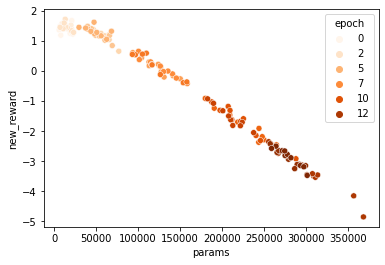

In [24]:

ax = sns.scatterplot(data=df_iterativeparams1, x='params', y='reward2', hue='epoch', palette='Oranges')
ax.set(ylabel='new_reward')

<AxesSubplot:xlabel='params', ylabel='vals'>

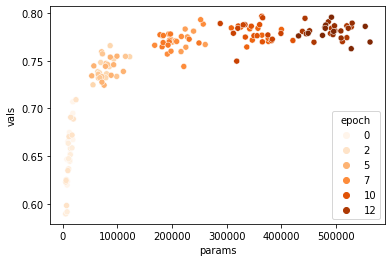

In [5]:
df_iterativeparams1 = get_df('iterativerandom1')
sns.scatterplot(data=df_iterativeparams1, x='params', y='vals', hue='epoch',  palette='Oranges')